This notebook is the culmination of all the work done in previous notebooks. It has the live game data and how it compares to several stats types. Using the information from this notebook a more robust and istant feed back live reporting NHL predictor can be created. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import plot_confusion_matrix
from sklearn.dummy import DummyClassifier

import joblib

In [2]:
box_model = pd.read_csv('./data_frames/bruins_isles_live_scrape_preds.csv')
minutes_model = pd.read_csv('./data_frames/bruins_isles_live_scrape_minutes_preds.csv')
minutes_model_art_1 = pd.read_csv('./data_frames/penguins_isles_artifical_live_scrape_minutes.csv')
minutes_model_art_2 = pd.read_csv('./data_frames/lighting_canes_artifical_scrape_minutes.csv')

In [3]:
box_differences = joblib.load('./models/random_forest_classifier.pkl')

getting prediction percentages for each minute. 

In [4]:
diff_preds = box_differences.predict_proba(box_model.drop(columns=['period','period_time','rfc_prediction']))
diff_preds =[x[1] for x in diff_preds]
box_model['win_percentage'] = diff_preds

In [5]:
def make_line_plot(df, prediction_column, target_column, scale = 1, prediction_color = 'red'):
    ticks = ['0:00','10:00','20:00','30:00','40:00','50:00','60:00']
    f, ax = plt.subplots()
    f.set_figheight(8)
    f.set_figwidth(10)
    ax.plot(df['period_time'], (df[prediction_column]-.5), color=prediction_color, label = 'Percent chance to win above 50%')
    ax.plot(df['period_time'], (df[target_column]/scale), label= f'{target_column} differental (scaled down x{scale})')
    ax.set_xlim(0,6000)
    ax.set_title(f'Live Game Prediction vs {target_column} Differential', size = 20)
    ax.set_ylabel('Relative Values', size = 15)
    ax.set_xlabel('Time Into Game (minutes)', size = 15)
    ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
    ax.set_xticklabels(ticks)
    ax.legend();


Predictions of the differences in box scores model, and how they compare to certain tracked stats. Also an evaluation on the effectiveness of the model. 

In [6]:
box_model.head()

,shots,blocked_shots,penalty_minutes,power_play_percentage,power_play_goals,power_play_chances,faceoff_percent,takeaways,giveaways,hits,ice_tilt,period,period_time,rfc_prediction,win_percentage
0,0,0,0,0.0,0.0,0.0,100.0,0,0,0,-69.0,1,8,yes,0.504487
1,0,0,0,0.0,0.0,0.0,100.0,0,0,0,-152.0,1,126,yes,0.504487
2,0,1,0,0.0,0.0,0.0,100.0,1,0,-1,-154.0,1,211,yes,0.508222
3,2,0,0,0.0,0.0,0.0,100.0,1,0,-2,-274.0,1,259,yes,0.529556
4,2,0,0,0.0,0.0,0.0,0.0,1,0,-2,-385.0,1,259,no,0.483156


In [7]:
model_train_df = pd.read_csv('./data_frames/game_stats_differences_2020.csv')
X = model_train_df.drop(columns=['won', 'goal_diff','goals','game_ids', ])
y = model_train_df['won']

X_train, X_test, y_train, y_test = train_test_split(X,y, random_state = 42)

In [8]:
dc = DummyClassifier(strategy='most_frequent')
dc.fit(X,y)
print(f'dummy score: {dc.score(X,y)}')
null_preds = dc.predict(X)

dummy score: 0.5023041474654378


In [9]:
box_differences.score(X_test,y_test), box_differences.score(X_train,y_train)

(0.7142857142857143, 0.7035330261136713)

Scores are still coming in right around 70% accuracy, which is what we expected. 

In [10]:
rfc_preds = box_differences.predict(X_test)

<Figure size 720x720 with 0 Axes>

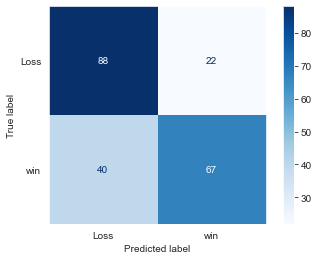

In [11]:
sns.set_style('dark')
plt.figure(figsize=(10,10))
plot_confusion_matrix(box_differences, X_test, y_test, cmap='Blues',display_labels=['Loss', 'win']);    

We can see that the model is performing reasonably well considering sports data. The model doest use the score of the game to try and determine the winner, and is still correct 70% of the time! It does not struggle with overfitting thankfully, so it seems like it could be a strong model to check for overall game success rate. The model does significantly outperform the baseline model, so it does seem to have merrit as something to be used for predicting the winner of a game. 

In [12]:
ticks = ['0:00','10:00','20:00','30:00','40:00','50:00','60:00']

In [50]:
sns.set_style('darkgrid')

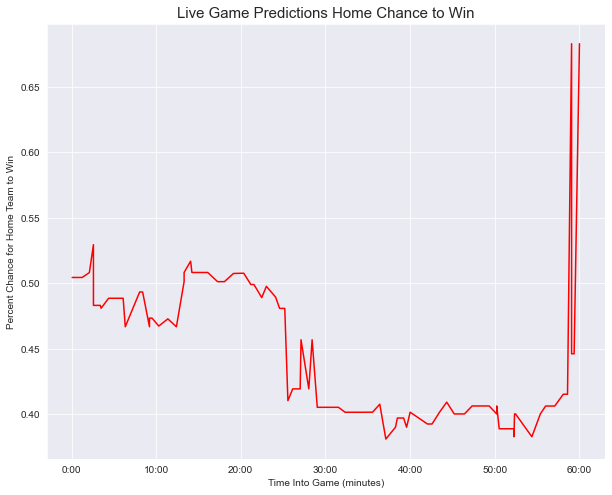

In [51]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(box_model['period_time'], (box_model['win_percentage']), color='red', label = 'Percent chance to win')
ax.set_title('Live Game Predictions Home Chance to Win', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Percent Chance for Home Team to Win', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks);

Knowing that the Tampa Bay Lighting lost this game, despite a late desperation push to attempt to win, this chance to win graph makes a lot of sense. The game was mostly dominated by the road team, the New York Islanders, and the chance to win reflects that. 

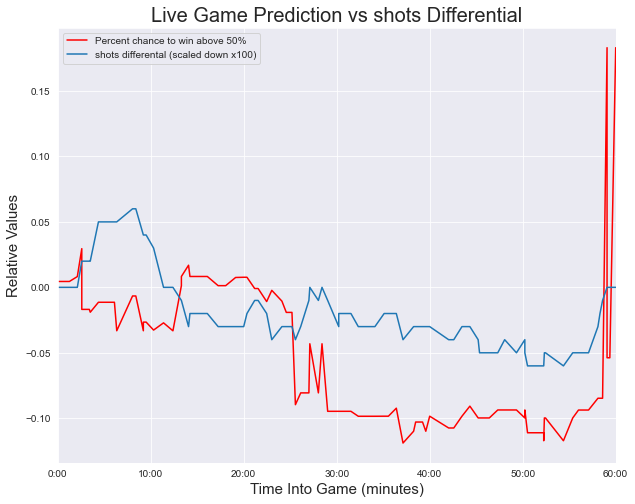

In [15]:
make_line_plot(box_model,'win_percentage','shots', 100)

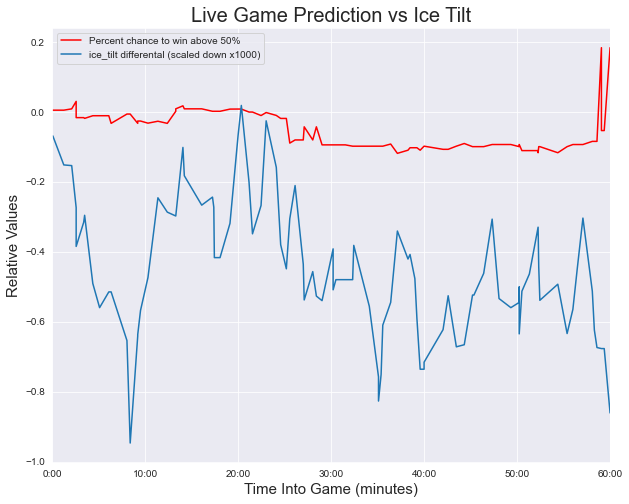

In [16]:
make_line_plot(box_model,'win_percentage','ice_tilt', 1000)
plt.title('Live Game Prediction vs Ice Tilt', size =20);

In the two graphs above, you can see the effect some of the features have on the chance to win. Shots does seem to have a more direct correlation with the chance to win prediction, but there is also some correlation with ice tilt.

Now working with the minute over minute modeling

In [17]:
random_forest = pd.read_csv('./data_frames/minute_rf_scores.csv')
log_reg = pd.read_csv('./data_frames/minute_log_reg_scores.csv')

Comparing the train and validation data for the minute over minute models. As expected the closer we got to the end of the game the more accuracy was found in the model. 

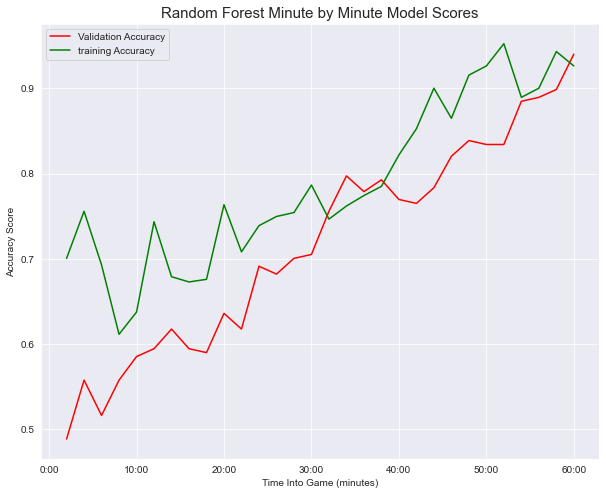

In [52]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(random_forest['minutes_into_game'], random_forest['test_score'], color = 'red', label = 'Validation Accuracy')  
ax.plot(random_forest['minutes_into_game'], random_forest['train_score'],color = 'green', label = 'training Accuracy')
ax.set_title('Random Forest Minute by Minute Model Scores', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Accuracy Score', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks)
ax.legend();

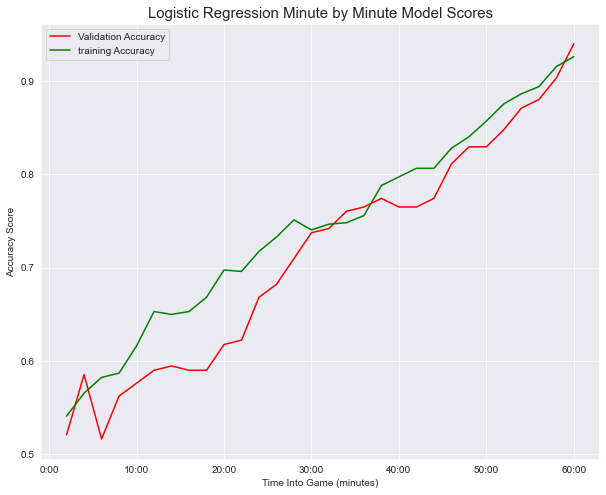

In [53]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(log_reg['minutes_into_game'], log_reg['test_score'], color = 'red', label = 'Validation Accuracy')  
ax.plot(log_reg['minutes_into_game'], log_reg['train_score'],color = 'green', label = 'training Accuracy')
ax.set_title('Logistic Regression Minute by Minute Model Scores', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Accuracy Score', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks)
ax.legend();

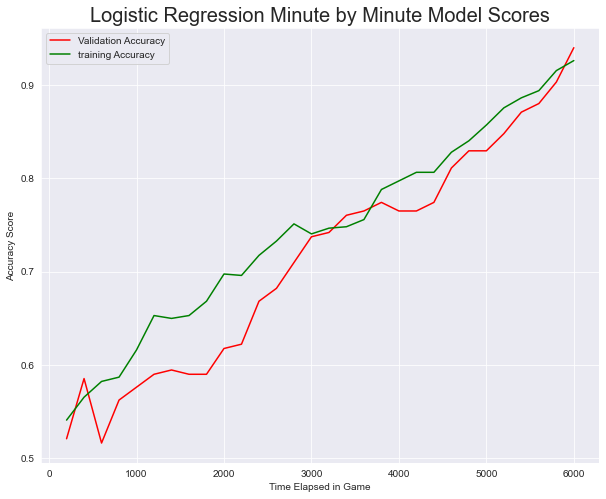

In [46]:
plt.figure(figsize=(10,8))
plt.plot(log_reg['minutes_into_game'], log_reg['test_score'], color = 'red', label = 'Validation Accuracy')  
plt.plot(log_reg['minutes_into_game'], log_reg['train_score'],color = 'green', label = 'training Accuracy')
plt.title('Logistic Regression Minute by Minute Model Scores', size = 20)
plt.xlabel('Time Elapsed in Game')
plt.ylabel('Accuracy Score')
plt.legend();

Looking at these two graphs of model performance, I decided to go with the logistic regression. It has less struggles with overfitting than the random forest, and still gains relatively good predictive power quickly as the game goes on. 

Live Scrapped Game

In [21]:
minutes_model.tail()

,Goal,Shot,Blocked Shot,Faceoff,Takeaway,Giveaway,Hit,Missed Shot,Penalty,period_time,predictions,probability_win
91,-2,0,-4,-10,2,6,-1,3,1,5831,no,0.000000
92,-2,1,-5,-10,2,6,-1,3,1,5859,no,0.000000
93,-1,1,-5,-10,2,6,-1,3,1,5907,no,0.000000
94,-1,1,-5,-11,2,6,-1,3,1,5937,no,0.045455
95,-1,1,-5,-10,2,6,-1,5,1,6000,no,0.000000


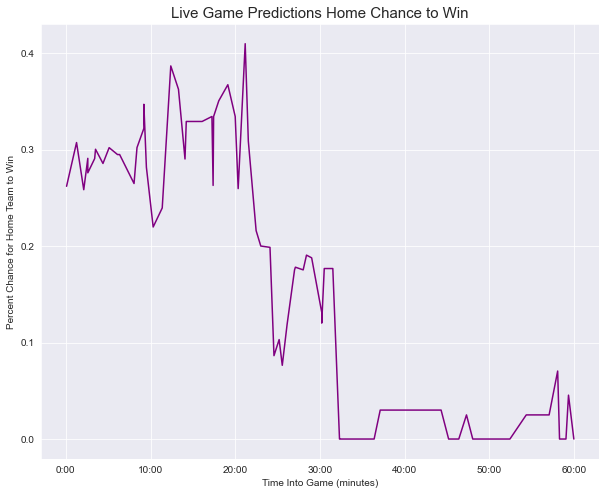

In [44]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(minutes_model['period_time'], (minutes_model['probability_win']), color='purple', label = 'Percent chance to win full games')
ax.set_title('Live Game Predictions Home Chance to Win', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Percent Chance for Home Team to Win', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks);

We can see that this version of the model is particularly harsher, especially in the later stages of the game. It is much more willing to predict a team to have next to zero, or even zero chance to win games. This could becuase the models high accuracy as the game goes on. 

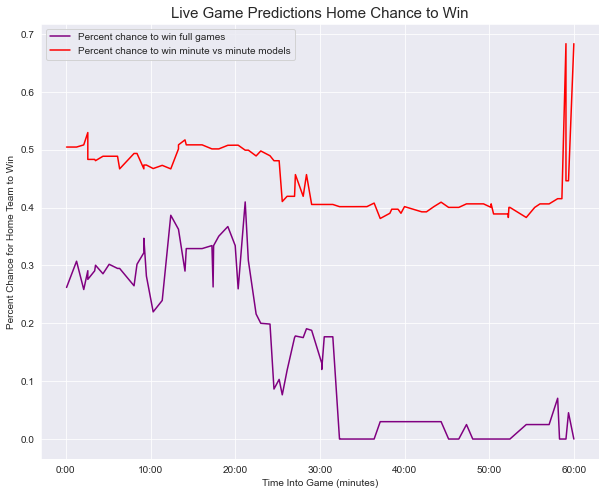

In [56]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(minutes_model['period_time'], (minutes_model['probability_win']), color='purple', label = 'Percent chance to win full games')
ax.plot(box_model['period_time'], (box_model['win_percentage']), color='red', label = 'Percent chance to win minute vs minute models')
ax.set_title('Live Game Predictions Home Chance to Win', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Percent Chance for Home Team to Win', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks)
ax.legend();

Comparing the two, we see the minute by minute model is much harsher on Tampa Bay in this game. It gives them significantly less chance to win in the later stages of the game, and isnt and affected by their late game comeback attempt. 

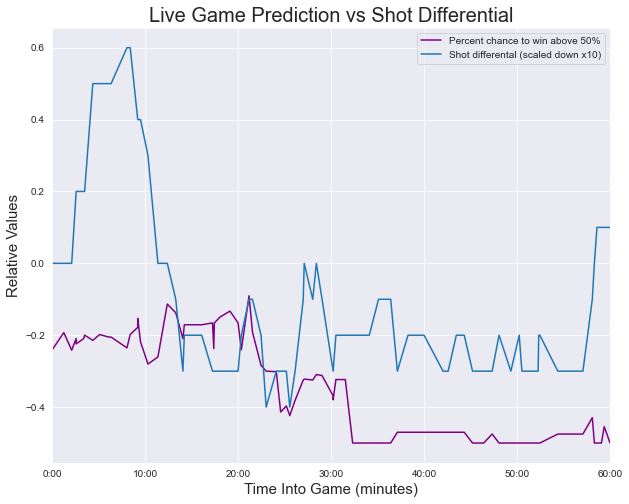

In [24]:
make_line_plot(minutes_model,'probability_win','Shot', 10, prediction_color='purple')

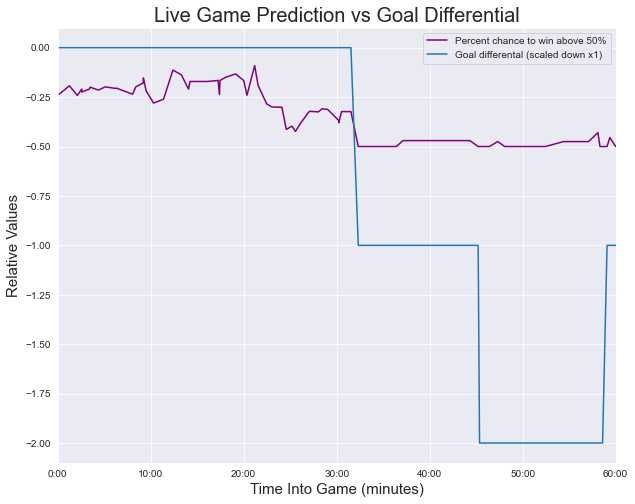

In [25]:
make_line_plot(minutes_model,'probability_win','Goal', prediction_color='purple')

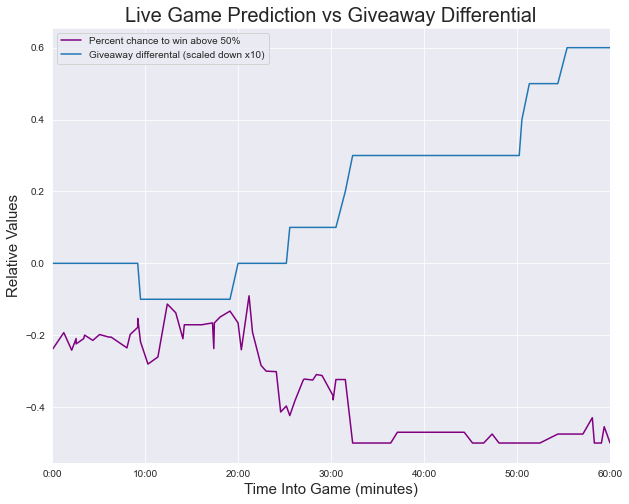

In [26]:
make_line_plot(minutes_model,'probability_win', 'Giveaway', 10, prediction_color='purple' )

In these three graphs we can see the effect of goals, shots and giveaways on the model. Goals clearly has the strongest impact, especially as the game goes on, but as the TV commentary for the game that night mentioned, giveways also played a big role. 

now for the artifical scrapes

In [28]:
period_times_artifical = [x for x in range(200,6001,200)]

In [29]:
minutes_model_art_1['period_time'] = period_times_artifical
minutes_model_art_2['period_time'] = period_times_artifical

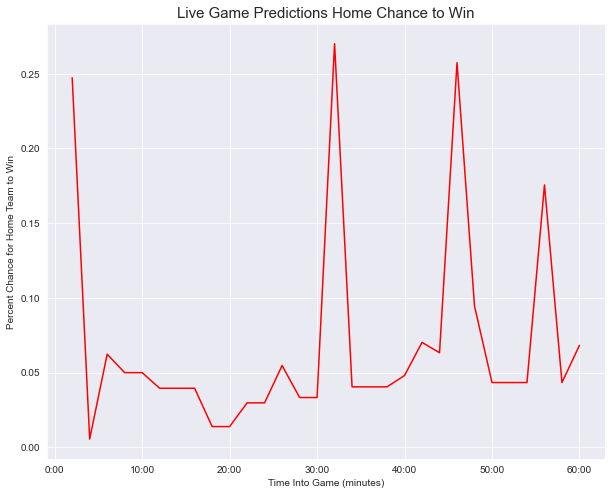

In [41]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(minutes_model_art_1['period_time'], (minutes_model_art_1['probability_win']), color='red', label = 'Percent chance to win')
ax.set_title('Live Game Predictions Home Chance to Win', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Percent Chance for Home Team to Win', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks);

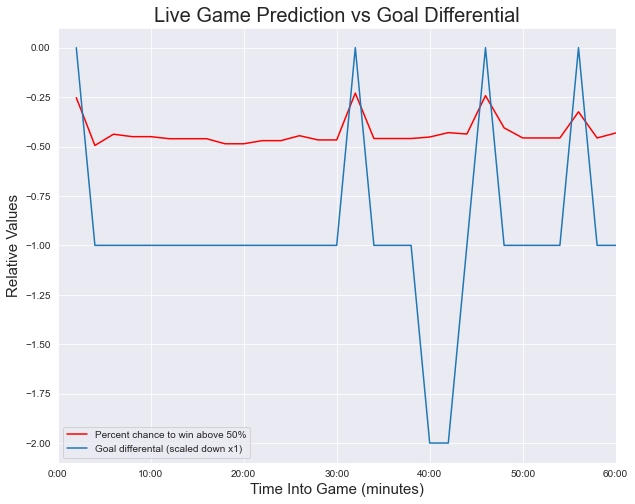

In [31]:
make_line_plot(minutes_model_art_1, 'probability_win', 'Goal')

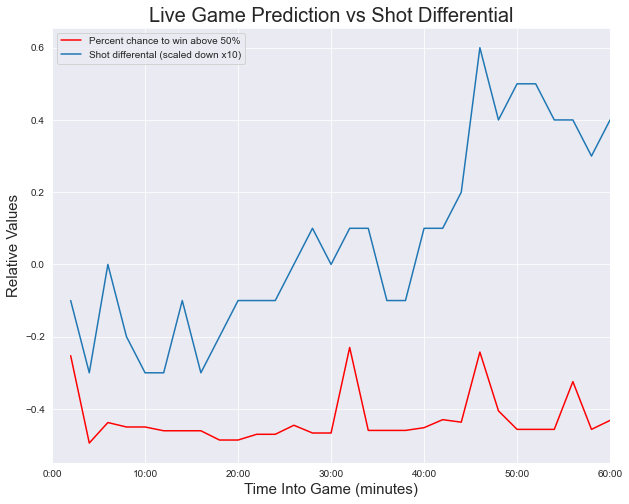

In [32]:
make_line_plot(minutes_model_art_1, 'probability_win', 'Shot', 10)

Looking at the data in these three graphs, showing the results of the first artifical scrape we can see that despite their best comeback attempts, the home team, the New York Islanders was never heavily favored to win. They were getting outplayed pretty hard in most of the other stats 

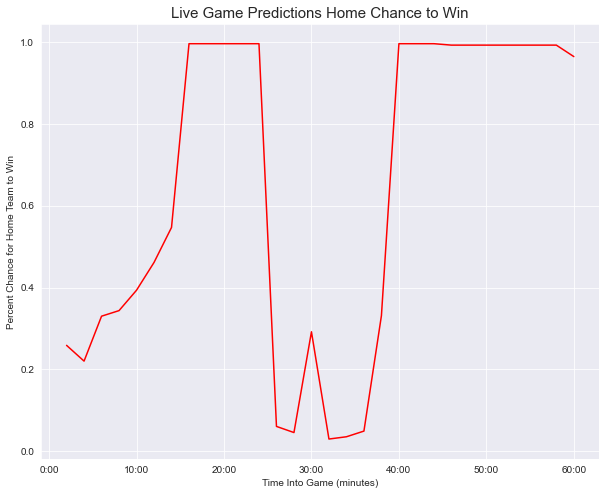

In [40]:
f,ax = plt.subplots()
f.set_figheight(8)
f.set_figwidth(10)
ax.plot(minutes_model_art_2['period_time'], (minutes_model_art_2['probability_win']), color='red', label = 'Percent chance to win')
ax.set_title('Live Game Predictions Home Chance to Win', size = 15)
ax.set_xlabel('Time Into Game (minutes)', size = 10)
ax.set_ylabel('Percent Chance for Home Team to Win', size = 10)
ax.set_xticks([0,1000,2000,3000,4000,5000,6000])
ax.set_xticklabels(ticks);

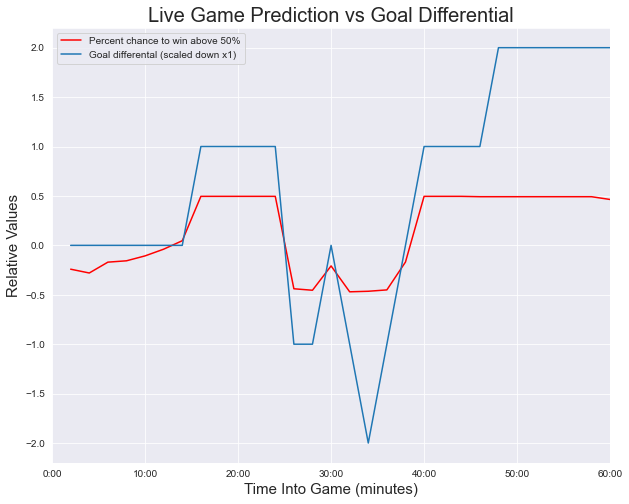

In [34]:
make_line_plot(minutes_model_art_2, 'probability_win', 'Goal')

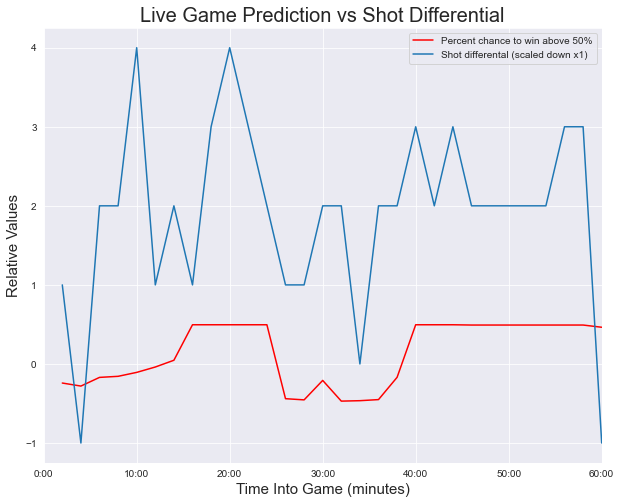

In [35]:
make_line_plot(minutes_model_art_2, 'probability_win', 'Shot')

This second artifical scrape shows the weakness of the minute by minute model. It tends to overreact to the goals, especially when other stats are held equal. This model switched from zero percent chance to win, to 100% chance to win, and back several times within a game. The model probably needs tuning to help deal with the over reliance on goals. 